# 定义模型结构

In [9]:
import os
import math
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchinfo import summary
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import datasets, transforms, utils
from torch.utils.tensorboard import SummaryWriter


# ==========================================
# 0. 工具函数：固定随机种子 & 早停
# ==========================================
def set_seed(seed=42):
    """
    固定各种随机种子，确保实验可复现。
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 如果使用多GPU

    # 保证 CuDNN 算法的确定性 (会稍微牺牲一点性能，但保证结果一致)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"随机种子已设置为: {seed}")


class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        is_best = False
        if self.best_loss is None:
            self.best_loss = val_loss
            is_best = True
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f"早停计数器: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
            is_best = True
        return is_best


# ==========================================
# 1. 配置模块
# ==========================================
class Config:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    img_size = 28
    batch_size = 128
    timesteps = 1000
    epochs = 100
    lr = 2e-4
    dim_h = 64
    patience = 10
    num_classes = 10
    seed = 42
    # 路径
    log_dir = f"./runs/mnist_diffusion"
    model_save_dir = os.path.join(log_dir, "checkpoints")

    @staticmethod
    def initialize():
        os.makedirs(Config.model_save_dir, exist_ok=True)
        set_seed(Config.seed)  # 初始化时设置种子
        print(f"训练日志将保存在: {Config.log_dir}")


# ==========================================
# 2. 网络结构
# ==========================================

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.downsample = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        h = self.relu(self.bn1(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(...,) + (None,) * 2]
        h = h + time_emb
        h = self.relu(self.bn2(self.conv2(h)))
        return self.downsample(h)


class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.upsample = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        h = self.relu(self.bn1(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(...,) + (None,) * 2]
        h = h + time_emb
        h = self.relu(self.bn2(self.conv2(h)))
        return self.upsample(h)


class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (Config.dim_h, Config.dim_h * 2, Config.dim_h * 4)
        up_channels = (Config.dim_h * 4, Config.dim_h * 2, Config.dim_h)
        out_dim = image_channels
        time_emb_dim = 32

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        self.label_emb = nn.Embedding(Config.num_classes, time_emb_dim)

        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        self.downs = nn.ModuleList([
            DownBlock(down_channels[0], down_channels[1], time_emb_dim),
            DownBlock(down_channels[1], down_channels[2], time_emb_dim),
        ])

        self.ups = nn.ModuleList([
            UpBlock(down_channels[2], up_channels[1], time_emb_dim),
            UpBlock(up_channels[1], up_channels[2], time_emb_dim),
        ])

        self.output = nn.Conv2d(up_channels[2], out_dim, 1)

    def forward(self, x, timestep, labels):
        t = self.time_mlp(timestep)
        c = self.label_emb(labels)
        t = t + c

        x = self.conv0(x)

        residuals = []
        for down in self.downs:
            x = down(x, t)
            residuals.append(x)

        for up in self.ups:
            residual = residuals.pop()
            x = torch.cat((x, residual), dim=1)
            x = up(x, t)

        return self.output(x)


# ==========================================
# 3. 扩散模型逻辑
# ==========================================
class DiffusionEngine:
    def __init__(self):
        self.timesteps = Config.timesteps
        self.device = Config.device
        self.beta = torch.linspace(1e-4, 0.02, self.timesteps).to(self.device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
        self.sqrt_alpha_hat = torch.sqrt(self.alpha_hat)
        self.sqrt_one_minus_alpha_hat = torch.sqrt(1. - self.alpha_hat)

    def add_noise(self, x, t):
        # 这里的 noise 也是随机的，受 seed 控制
        sqrt_alpha_hat_t = self.sqrt_alpha_hat[t][:, None, None, None]
        sqrt_one_minus_alpha_hat_t = self.sqrt_one_minus_alpha_hat[t][:, None, None, None]

        noise = torch.randn_like(x)
        x_t = sqrt_alpha_hat_t * x + sqrt_one_minus_alpha_hat_t * noise
        return x_t, noise

    @torch.no_grad()
    def sample(self, model, n_samples, labels=None):
        model.eval()
        if labels is None:
            labels = torch.randint(0, Config.num_classes, (n_samples,)).to(self.device)
        else:
            labels = labels.to(self.device)
            n_samples = labels.shape[0]

        print(f"Sampling {n_samples} images...")

        # 初始噪声，受 seed 控制
        x = torch.randn((n_samples, 1, Config.img_size, Config.img_size)).to(self.device)

        for i in tqdm(reversed(range(1, self.timesteps)), desc="Sampling", total=self.timesteps - 1):
            t = (torch.ones(n_samples) * i).long().to(self.device)
            predicted_noise = model(x, t, labels)

            alpha = self.alpha[t][:, None, None, None]
            alpha_hat = self.alpha_hat[t][:, None, None, None]
            beta = self.beta[t][:, None, None, None]

            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)

            x = (1 / torch.sqrt(alpha)) * (
                    x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise

        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        return x

    @torch.no_grad()
    def sample_steps(self, model, label, steps_to_save):
        """
        返回形状为 (len(steps), 1, H, W)
        这样就能直接 utils.make_grid 使用！
        """
        model.eval()
        label = torch.tensor([label]).long().to(self.device)

        x = torch.randn((1, 1, Config.img_size, Config.img_size)).to(self.device)

        saved_list = []  # 重要：改成 list
        steps_to_save = sorted(steps_to_save, reverse=True)
        steps_set = set(steps_to_save)

        for i in reversed(range(1, self.timesteps)):
            t = torch.tensor([i]).long().to(self.device)
            predicted_noise = model(x, t, label)

            alpha = self.alpha[t][:, None, None, None]
            alpha_hat = self.alpha_hat[t][:, None, None, None]
            beta = self.beta[t][:, None, None, None]

            noise = torch.randn_like(x) if i > 1 else torch.zeros_like(x)

            x = (1 / torch.sqrt(alpha)) * (
                    x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise
            ) + torch.sqrt(beta) * noise

            if i in steps_set:
                x_show = (x.clamp(-1, 1) + 1) / 2  # 0~1
                saved_list.append(x_show.cpu())  # 直接收集 tensor

        # 拼成 (N, 1, H, W)
        return torch.cat(saved_list, dim=0)


# ==========================================
# 4. 数据与训练辅助
# ==========================================
def get_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # DataLoader 的 shuffle 也会受 seed 影响
    train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, drop_last=True)
    val_loaval_loaderder = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False, drop_last=True)

    return train_loader, val_loader

# 模型训练
## 初始化并设置随机种子

In [ ]:
Config.initialize()

train_loader, val_loader = get_data()
model = SimpleUNet().to(Config.device)
optimizer = torch.optim.AdamW(model.parameters(), lr=Config.lr)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.epochs)
mse = nn.MSELoss()
diffusion = DiffusionEngine()
writer = SummaryWriter(log_dir=Config.log_dir)

## 添加 TensorBoard 模型结构可视化

In [ ]:
dummy_x = torch.randn(1, 1, 64, 64).to(Config.device)
dummy_t = torch.randint(1, Config.timesteps, (1,)).to(Config.device)
dummy_label = torch.tensor([0]).long().to(Config.device)

try:
    writer.add_graph(model, (dummy_x, dummy_t, dummy_label))
    print("TensorBoard 模型结构图已记录！在 TensorBoard 的 Graph 标签下查看。")
except Exception as e:
    print("TensorBoard Graph 记录失败（PyTorch 中部分动态图可能不完全支持）：", e)

torch.onnx.export(
    model,
    (dummy_x, dummy_t, dummy_label),
    os.path.join(Config.log_dir, "simple_unet.onnx"),
    opset_version=17,
    input_names=["x", "timestep", "labels"],
    output_names=["output"],
    dynamic_axes={
        "x": {0: "batch"},
        "labels": {0: "batch"},
        "timestep": {0: "batch"},
        "output": {0: "batch"}
    }
)

print("ONNX 已保存为 simple_unet.onnx，可以用 Netron 打开")

summary(
    model,
    input_size=[(1, 1, 64, 64), (1,), (1,)],
    dtypes=[torch.float, torch.long, torch.long],
    col_names=["input_size", "output_size", "kernel_size"],
)

## 开始训练

In [ ]:
early_stopping = EarlyStopping(patience=Config.patience)
global_step = 0

print("开始训练 (Conditional Diffusion with Fixed Seed & EarlyStopping)...")

for epoch in range(Config.epochs):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{Config.epochs}")
    train_loss_accum = 0

    for batch_idx, (images, labels) in enumerate(pbar):
        images = images.to(Config.device)
        labels = labels.to(Config.device)

        # 这里的 randint 也会因为 seed 固定而产生固定的序列
        t = torch.randint(1, Config.timesteps, (images.shape[0],)).to(Config.device)
        x_t, noise = diffusion.add_noise(images, t)
        predicted_noise = model(x_t, t, labels)

        loss = mse(predicted_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_accum += loss.item()
        writer.add_scalar("Loss/Train_Step", loss.item(), global_step)
        global_step += 1
        pbar.set_postfix(MSE=loss.item())

    scheduler.step()
    avg_train_loss = train_loss_accum / len(train_loader)

    # Validation
    model.eval()
    val_loss_accum = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(Config.device)
            labels = labels.to(Config.device)
            t = torch.randint(1, Config.timesteps, (images.shape[0],)).to(Config.device)
            x_t, noise = diffusion.add_noise(images, t)
            predicted_noise = model(x_t, t, labels)
            loss = mse(predicted_noise, noise)
            val_loss_accum += loss.item()

    avg_val_loss = val_loss_accum / len(val_loader)

    writer.add_scalar("Loss/Train_Epoch", avg_train_loss, epoch)
    writer.add_scalar("Loss/Val_Epoch", avg_val_loss, epoch)

    print(f"Epoch {epoch + 1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Visualization
    if (epoch + 1) % 5 == 0 or epoch == 0:
        sampled_images = diffusion.sample(model, n_samples=10, labels=torch.arange(10).long().to(Config.device))
        grid = utils.make_grid(sampled_images, nrow=5)
        writer.add_image("Generated/Conditional_0-9", grid, epoch)
        print("生成 0-9 图像已保存到 TensorBoard")

    # 调用早停逻辑
    is_best = early_stopping(avg_val_loss)

    if is_best:
        save_path = os.path.join(Config.model_save_dir, "best_model.pth")
        torch.save(model.state_dict(), save_path)
        print(f"发现更优模型，已保存至: {save_path}")

    if early_stopping.early_stop:
        print("触发早停机制，训练结束。")
        break

writer.close()
print("训练完成！")

# 查看效果

In [10]:
diffusion = DiffusionEngine()
model = SimpleUNet().to(Config.device)
best_path = os.path.join(Config.model_save_dir, "best_model.pth")
model.load_state_dict(torch.load(best_path, map_location=Config.device))
model.eval()
print(f"已加载最优模型: {best_path}")

已加载最优模型: ./runs/mnist_diffusion/checkpoints/best_model.pth


In [11]:
from torchinfo import summary

dummy_x = torch.randn(1, 1, 64, 64).to(Config.device)
dummy_t = torch.randint(1, Config.timesteps, (1,)).to(Config.device)
dummy_label = torch.tensor([0]).long().to(Config.device)
summary(model, input_data=(dummy_x, dummy_t, dummy_label))

Layer (type:depth-idx)                        Output Shape              Param #
SimpleUNet                                    [1, 1, 64, 64]            --
├─Sequential: 1-1                             [1, 32]                   --
│    └─SinusoidalPositionEmbeddings: 2-1      [1, 32]                   --
│    └─Linear: 2-2                            [1, 32]                   1,056
│    └─ReLU: 2-3                              [1, 32]                   --
├─Embedding: 1-2                              [1, 32]                   320
├─Conv2d: 1-3                                 [1, 64, 64, 64]           640
├─ModuleList: 1-4                             --                        --
│    └─DownBlock: 2-4                         [1, 128, 32, 32]          --
│    │    └─Conv2d: 3-1                       [1, 128, 64, 64]          73,856
│    │    └─BatchNorm2d: 3-2                  [1, 128, 64, 64]          256
│    │    └─ReLU: 3-3                         [1, 128, 64, 64]          --
│    │    

Sampling 10 images...


Sampling: 100%|██████████| 999/999 [00:02<00:00, 461.70it/s]


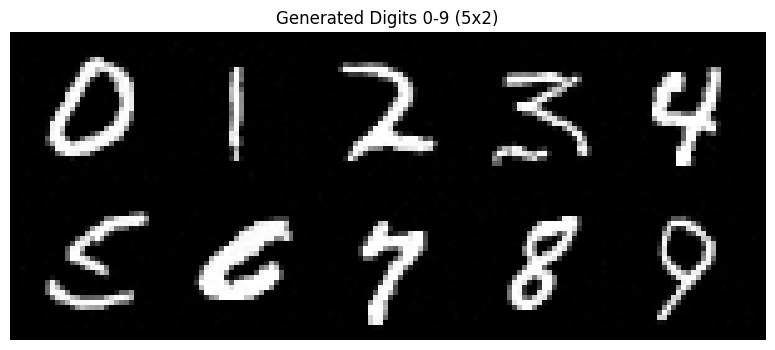

In [15]:
labels = torch.arange(10).long().to(Config.device)

with torch.no_grad():
    sampled_images = diffusion.sample(model, n_samples=10, labels=labels)
grid = utils.make_grid(sampled_images, nrow=5)

plt.figure(figsize=(10, 4))
plt.imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
plt.axis("off")
plt.title("Generated Digits 0-9 (5x2)")
plt.show()

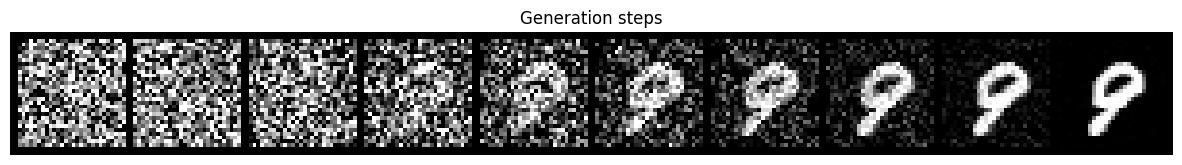

In [13]:
steps = [900, 700, 500, 400, 300, 200, 150, 100, 50, 1]
images = diffusion.sample_steps(model, label=9, steps_to_save=steps)

grid = utils.make_grid(images, nrow=len(steps))

plt.figure(figsize=(15, 3))
plt.imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
plt.axis("off")
plt.title("Generation steps")
plt.show()